In [2]:
!pip install ucimlrepo

In [1]:
# ============================================================================
# STEP 0: IMPORTS, SETTINGS & INSTALL NOTES
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

# Standard libs
import numpy as np
import pandas as pd
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.mixture import GaussianMixture

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Optional libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# Utility to display sections clearly
def show_header(title):
    print('\n' + '=' * 80)
    print(title)
    print('=' * 80 + '\n')

In [3]:
# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================

show_header('STEP 1: DATA LOADING')

# Primary method: ucimlrepo (same as original script)
try:
    from ucimlrepo import fetch_ucirepo
    print('Attempting to fetch dataset via ucimlrepo.fetch_ucirepo(id=222) ...')
    bank_marketing = fetch_ucirepo(id=222)
    X_original = bank_marketing.data.features
    y_original = bank_marketing.data.targets
    df = X_original.copy()
    # target column may be a DataFrame with single column
    df['y'] = y_original.iloc[:, 0]
    print('Dataset loaded via ucimlrepo.')
except Exception as e:
    print('ucimlrepo not available or failed:', str(e))
    # Fallback: try to read from a local CSV named 'bank_marketing.csv' or ask user to provide path
    try:
        print("Attempting to read local CSV 'bank_marketing.csv' ...")
        df = pd.read_csv('bank_marketing.csv')
        if 'y' not in df.columns and 'y' in df.columns.str.lower():
            # try lowercase
            df.rename(columns={c: 'y' for c in df.columns if c.lower() == 'y'}, inplace=True)
        print('Loaded local CSV.')
    except Exception as e2:
        raise RuntimeError('Unable to load dataset. Install ucimlrepo or provide bank_marketing.csv in working dir.')

# Normalize the target to binary 0/1 if necessary
if df['y'].dtype == 'object' or df['y'].dtype == 'bool':
    df['y'] = (df['y'] == 'yes').astype(int)

print(f"Dataset Shape: {df.shape}")
print(f"Response Rate: {df['y'].mean():.2%}")
print('\nColumns:\n', df.columns.tolist())

# Quick head
print('\nSample rows:')
print(df.head())

# %% [markdown]
# ## Notes on Data Loading
# - If `ucimlrepo` works, the script uses it. Otherwise it attempts to load a local CSV `bank_marketing.csv`.
# - Ensure 'y' exists and is binary (yes/no). We normalize it to 0/1.


STEP 1: DATA LOADING

Attempting to fetch dataset via ucimlrepo.fetch_ucirepo(id=222) ...
Dataset loaded via ucimlrepo.
Dataset Shape: (45211, 17)
Response Rate: 11.70%

Columns:
 ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

Sample rows:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  y  
0     NaN            5   may       261         1     -1         0      NaN  0  
1     NaN            5 

In [4]:
# ============================================================================
# STEP 2: FEATURE ENGINEERING (SAFE & EXPLAINED)
# ============================================================================

show_header('STEP 2: FEATURE ENGINEERING')

# Work on a copy
df_enhanced = df.copy()

# --- Create boolean flags for housing/loan BEFORE encoding ---
for col in ['housing', 'loan']:
    if col in df_enhanced.columns:
        df_enhanced[f'{col}_flag'] = (df_enhanced[col].astype(str).str.lower() == 'yes').astype(int)

# 1) Temporal features: month -> numeric, cyclical encoding, weekday
month_mapping = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
if 'month' in df_enhanced.columns:
    df_enhanced['month_num'] = df_enhanced['month'].map(month_mapping)
    # Handle missing months
    df_enhanced['month_num'] = df_enhanced['month_num'].fillna(0).astype(int)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month_num'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month_num'] / 12)

# day_of_week
day_mapping = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5,'sat':6,'sun':7}
if 'day_of_week' in df_enhanced.columns:
    df_enhanced['day_num'] = df_enhanced['day_of_week'].map(day_mapping).fillna(0).astype(int)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_num'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_num'] / 7)
    df_enhanced['is_weekend'] = (df_enhanced['day_num'] > 5).astype(int)

# 2) Behavioral scoring: contact intensity, prev_success_rate, engagement
if 'campaign' in df_enhanced.columns:
    max_campaign = df_enhanced['campaign'].max() if df_enhanced['campaign'].max() > 0 else 1
    df_enhanced['contact_intensity'] = df_enhanced['campaign'] / (max_campaign + 1)
else:
    df_enhanced['contact_intensity'] = 0

# prev_success_rate: use poutcome == 'success' but only where previous > 0
if 'previous' in df_enhanced.columns and 'poutcome' in df_enhanced.columns:
    df_enhanced['prev_success_rate'] = np.where(df_enhanced['previous'] > 0,
                                                (df_enhanced['poutcome'].astype(str).str.lower() == 'success').astype(int),
                                                0)
else:
    df_enhanced['prev_success_rate'] = 0

# duration buckets and engagement score
if 'duration' in df_enhanced.columns:
    duration_q = df_enhanced['duration'].quantile([0.25,0.5,0.75]).to_list()
    # Ensure unique and sorted
    bins = [0] + duration_q + [df_enhanced['duration'].max()+1]
    try:
        df_enhanced['duration_bucket'] = pd.cut(df_enhanced['duration'], bins=bins, labels=['Short','Medium','Long','Very_Long'], include_lowest=True)
    except Exception:
        # fallback if not enough unique bins
        df_enhanced['duration_bucket'] = 'Medium'

    # engagement score (normalize duration)
    dur_max = df_enhanced['duration'].max() if df_enhanced['duration'].max() > 0 else 1
    df_enhanced['engagement_score'] = (
        (df_enhanced['duration'] / dur_max) * 0.4 +
        (1 / (df_enhanced.get('campaign', 0) + 1)) * 0.3 +
        df_enhanced['prev_success_rate'] * 0.3
    )
else:
    df_enhanced['duration_bucket'] = 'NA'
    df_enhanced['engagement_score'] = 0

# 3) Demographic interactions
if 'age' in df_enhanced.columns:
    df_enhanced['age_group_detailed'] = pd.cut(df_enhanced['age'], bins=[0,25,35,45,55,65,200], labels=['18-25','26-35','36-45','46-55','56-65','65+'])

if 'education' in df_enhanced.columns and 'job' in df_enhanced.columns:
    df_enhanced['edu_job_interaction'] = df_enhanced['education'].astype(str) + '_' + df_enhanced['job'].astype(str)

# 4) Economic context (normalize common econ vars)
econ_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for var in econ_vars:
    if var in df_enhanced.columns:
        df_enhanced[f'{var}_normalized'] = (df_enhanced[var] - df_enhanced[var].mean()) / (df_enhanced[var].std() if df_enhanced[var].std() != 0 else 1)

if all(var in df_enhanced.columns for var in econ_vars):
    df_enhanced['economic_sentiment'] = (
        -df_enhanced['emp.var.rate_normalized'] +
        df_enhanced['cons.conf.idx_normalized'] +
        -df_enhanced['euribor3m_normalized']
    )
else:
    df_enhanced['economic_sentiment'] = 0

print('Feature engineering completed. New columns added:')
new_cols = [c for c in df_enhanced.columns if c not in df.columns]
print(new_cols)

# Inspect a few rows
print(df_enhanced.head())

# %% [markdown]
# **Explanation**
# - We created temporal cyclical features (sin/cos) for month/day so models can capture seasonality.
# - Created behavioral features such as engagement score and contact intensity.
# - Created boolean flags for housing/loan *before* encoding to keep an interpretable numeric flag.


STEP 2: FEATURE ENGINEERING

Feature engineering completed. New columns added:
['housing_flag', 'loan_flag', 'month_num', 'month_sin', 'month_cos', 'day_num', 'day_sin', 'day_cos', 'is_weekend', 'contact_intensity', 'prev_success_rate', 'duration_bucket', 'engagement_score', 'age_group_detailed', 'edu_job_interaction', 'economic_sentiment']
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week  ... day_sin  day_cos  is_weekend  contact_intensity  \
0     NaN            5  ...     0.0      1.0           0           0.015625   
1     NaN            5  ...     0.0      1.0         

In [6]:
# ============================================================================
# STEP 3: PREPROCESSING (LABEL ENCODING + PREP)
# ============================================================================

show_header('STEP 3: PREPROCESSING')

# Copy to avoid modifying original enhanced df
df_proc = df_enhanced.copy()

# Identify categorical features to encode (object dtype)
cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns.tolist()
# exclude target if present
if 'y' in cat_cols:
    cat_cols.remove('y')

print('Categorical columns to encode:', cat_cols)

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Handle missing values in Categorical columns by converting to object first
    if pd.api.types.is_categorical_dtype(df_proc[col]):
        df_proc[col] = df_proc[col].astype('object').fillna('NA').astype(str)
    else:
        df_proc[col] = df_proc[col].fillna('NA').astype(str)

    try:
        df_proc[col] = le.fit_transform(df_proc[col])
        label_encoders[col] = le
    except Exception as e:
        print(f'Label encoding failed for {col}:', e)

# Assemble feature matrix X and target y
X_enhanced = df_proc.drop(columns=['y'])
y = df_proc['y']

print('Prepared X and y:')
print('X shape:', X_enhanced.shape)
print('y distribution:\n', y.value_counts(normalize=True))

# %% [markdown]
# **Explanation**
# - Label encoding is used for simplicity. If you prefer one-hot encoding for non-ordinal categories, swap with `pd.get_dummies()` or `OneHotEncoder` in a pipeline.


STEP 3: PREPROCESSING

Categorical columns to encode: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'duration_bucket', 'age_group_detailed', 'edu_job_interaction']
Prepared X and y:
X shape: (45211, 32)
y distribution:
 y
0    0.883015
1    0.116985
Name: proportion, dtype: float64



STEP 4: CUSTOMER SEGMENTATION (CLUSTERING)

Selected clustering features (15): ['age', 'job', 'marital', 'education', 'housing_flag', 'loan_flag', 'campaign', 'previous', 'duration', 'engagement_score', 'contact_intensity', 'economic_sentiment', 'month_num', 'day_num', 'prev_success_rate']


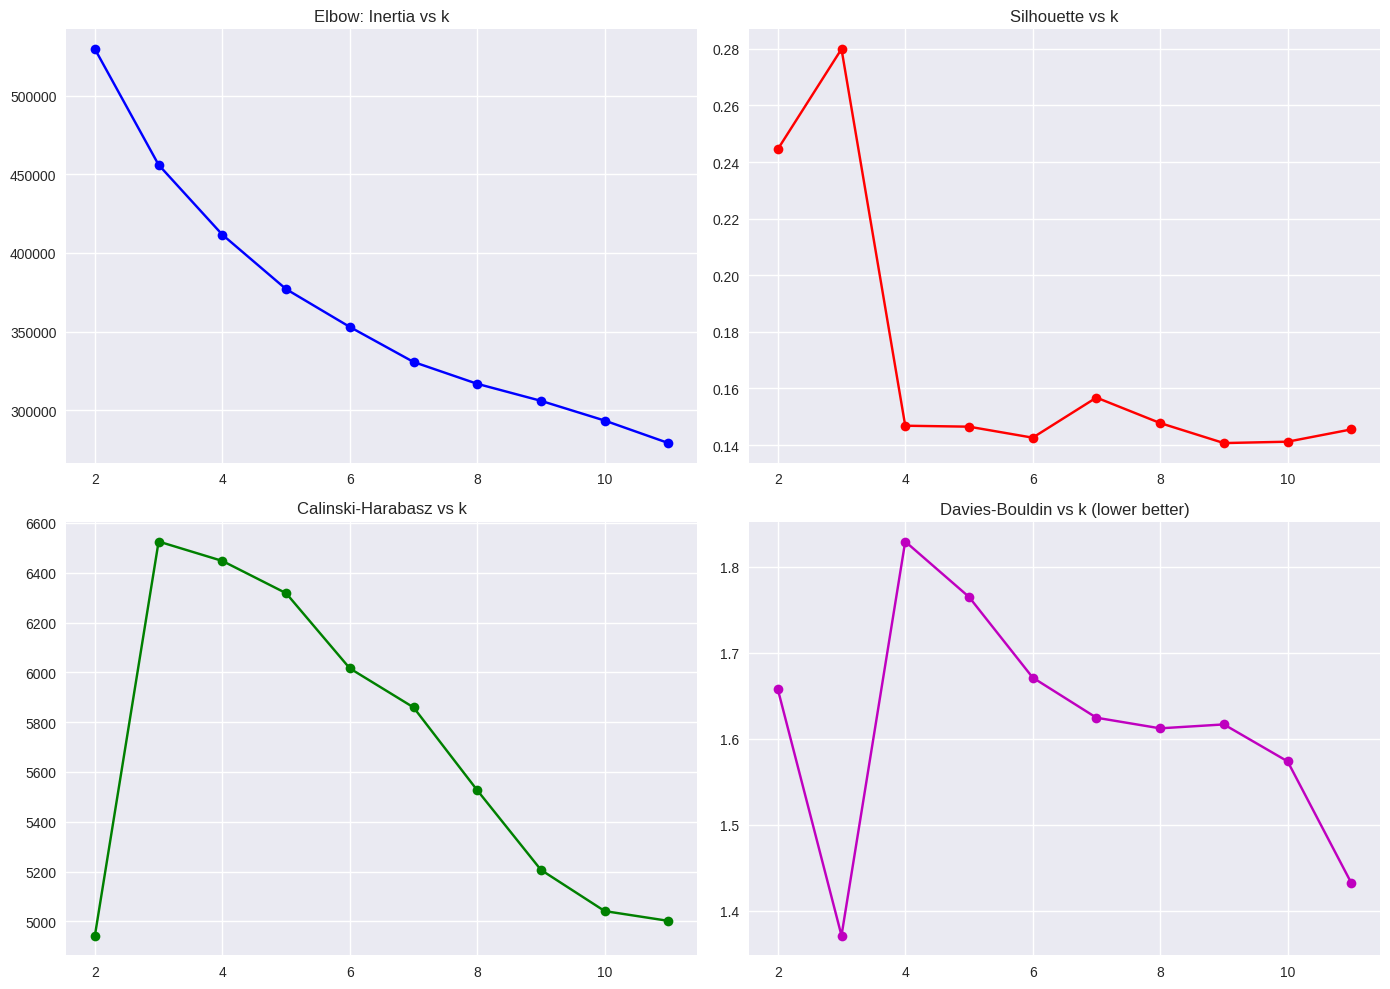

Selected k (by silhouette fallback): 3
Best clustering method: KMeans
Final silhouette score: 0.2799260118427872

Cluster Summary:


,Cluster,Size,Size_Pct,Response_Rate,Avg_Age,Avg_Duration,Avg_Campaign,Avg_Engagement,Pct_Housing,Pct_Loan
0,0,1515,3.351,0.647,42.972,320.109,1.807,0.446,0.314,0.055
1,1,39645,87.689,0.105,40.813,265.303,2.047,0.133,0.571,0.164
2,2,4051,8.960,0.038,41.385,165.122,10.133,0.045,0.502,0.167


In [7]:
# ============================================================================
# STEP 4: CUSTOMER SEGMENTATION (CLUSTERING)
# ============================================================================

show_header('STEP 4: CUSTOMER SEGMENTATION (CLUSTERING)')

# Candidate features for clustering (mix of demographics + behavior)
clustering_features = [
    'age', 'job', 'marital', 'education', 'housing_flag', 'loan_flag',
    'campaign', 'previous', 'duration', 'engagement_score', 'contact_intensity',
    'economic_stable' if 'economic_stable' in X_enhanced.columns else 'economic_sentiment',
    'month_num' if 'month_num' in X_enhanced.columns else 'month_sin',
    'day_num' if 'day_num' in X_enhanced.columns else 'day_sin',
    'prev_success_rate'
]

# Keep only available features
available_features = [f for f in clustering_features if f in X_enhanced.columns]
print(f'Selected clustering features ({len(available_features)}):', available_features)

# If no clustering features available, skip clustering
if len(available_features) == 0:
    print('No clustering features available; skipping clustering step.')
else:
    X_cluster = X_enhanced[available_features].copy()
    scaler_cluster = StandardScaler()
    X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

    # Determine optimal k via multiple metrics
    K_range = range(2, 12)
    metrics_results = {'k': [], 'inertia': [], 'silhouette': [], 'calinski_harabasz': [], 'davies_bouldin': []}

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_k = kmeans.fit_predict(X_cluster_scaled)
        metrics_results['k'].append(k)
        metrics_results['inertia'].append(kmeans.inertia_)
        # Some metrics require at least 2 clusters; safe-guard
        try:
            metrics_results['silhouette'].append(silhouette_score(X_cluster_scaled, labels_k))
        except Exception:
            metrics_results['silhouette'].append(np.nan)
        try:
            metrics_results['calinski_harabasz'].append(calinski_harabasz_score(X_cluster_scaled, labels_k))
        except Exception:
            metrics_results['calinski_harabasz'].append(np.nan)
        try:
            metrics_results['davies_bouldin'].append(davies_bouldin_score(X_cluster_scaled, labels_k))
        except Exception:
            metrics_results['davies_bouldin'].append(np.nan)

    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    axes[0].plot(metrics_results['k'], metrics_results['inertia'], 'bo-')
    axes[0].set_title('Elbow: Inertia vs k')
    axes[1].plot(metrics_results['k'], metrics_results['silhouette'], 'ro-')
    axes[1].set_title('Silhouette vs k')
    axes[2].plot(metrics_results['k'], metrics_results['calinski_harabasz'], 'go-')
    axes[2].set_title('Calinski-Harabasz vs k')
    axes[3].plot(metrics_results['k'], metrics_results['davies_bouldin'], 'mo-')
    axes[3].set_title('Davies-Bouldin vs k (lower better)')
    plt.tight_layout()
    plt.show()

    # pick a consensus (silhouette maximizer) with fallback
    try:
        optimal_k = K_range[int(np.nanargmax(metrics_results['silhouette']))]
    except Exception:
        optimal_k = 4
    print('Selected k (by silhouette fallback):', optimal_k)

    # Apply different clustering algorithms
    clustering_results = {}

    # KMeans
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_cluster_scaled)
    clustering_results['KMeans'] = {'labels': labels_km, 'model': kmeans, 'silhouette': silhouette_score(X_cluster_scaled, labels_km)}

    # GMM
    try:
        gmm = GaussianMixture(n_components=optimal_k, random_state=42)
        labels_gmm = gmm.fit_predict(X_cluster_scaled)
        clustering_results['GMM'] = {'labels': labels_gmm, 'model': gmm, 'silhouette': silhouette_score(X_cluster_scaled, labels_gmm)}
    except Exception:
        print('GMM failed; skipping')

    # DBSCAN heuristic
    try:
        from sklearn.neighbors import NearestNeighbors
        neigh = NearestNeighbors(n_neighbors=5)
        neigh.fit(X_cluster_scaled)
        dists, idx = neigh.kneighbors(X_cluster_scaled)
        kdist = np.sort(dists[:, -1])
        eps = np.percentile(kdist, 95)
        db = DBSCAN(eps=eps, min_samples=5)
        labels_db = db.fit_predict(X_cluster_scaled)
        if len(set(labels_db)) > 1:
            clustering_results['DBSCAN'] = {'labels': labels_db, 'model': db, 'silhouette': silhouette_score(X_cluster_scaled, labels_db)}
    except Exception:
        pass

    # Choose best clustering by silhouette
    best_clust_name = max(clustering_results.keys(), key=lambda x: clustering_results[x]['silhouette'])
    final_labels = clustering_results[best_clust_name]['labels']
    print('Best clustering method:', best_clust_name)
    print('Final silhouette score:', clustering_results[best_clust_name]['silhouette'])

    # Add labels back to df
    df_proc['cluster'] = final_labels
    X_enhanced['cluster'] = final_labels

    # Summarize clusters
    unique_clusters = sorted([c for c in set(final_labels) if c != -1])
    cluster_stats = []
    for cid in unique_clusters:
        mask = (final_labels == cid)
        cdata = df_proc[mask]
        stats = {
            'Cluster': cid,
            'Size': len(cdata),
            'Size_Pct': len(cdata) / len(df_proc) * 100,
            'Response_Rate': cdata['y'].mean(),
            'Avg_Age': cdata['age'].mean() if 'age' in cdata.columns else np.nan,
            'Avg_Duration': cdata['duration'].mean() if 'duration' in cdata.columns else np.nan,
            'Avg_Campaign': cdata['campaign'].mean() if 'campaign' in cdata.columns else np.nan,
            'Avg_Engagement': cdata['engagement_score'].mean() if 'engagement_score' in cdata.columns else np.nan,
            'Pct_Housing': cdata['housing_flag'].mean() if 'housing_flag' in cdata.columns else 0,
            'Pct_Loan': cdata['loan_flag'].mean() if 'loan_flag' in cdata.columns else 0,
        }
        cluster_stats.append(stats)

    cluster_df = pd.DataFrame(cluster_stats)
    print('\nCluster Summary:')
    display(cluster_df.round(3))

# %% [markdown]
# **Explanation**
# - Multiple metrics (silhouette, Calinski-Harabasz, Davies-Bouldin, inertia) are calculated to help choose `k`.
# - We apply KMeans, GMM and a DBSCAN heuristic and choose the clustering with the highest silhouette score.

In [8]:
# ============================================================================
# STEP 5: FEATURE SELECTION & TRAIN/TEST SPLIT
# ============================================================================

show_header('STEP 5: FEATURE SELECTION & TRAIN/TEST SPLIT')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)
print('Train/Test shapes:', X_train.shape, X_test.shape)

# Address class imbalance with SMOTE on training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print('After SMOTE, class distribution:', np.bincount(y_train_balanced))

# 1) SelectKBest (statistical)
k_select = min(30, X_train_balanced.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_select)
selector.fit(X_train_balanced, y_train_balanced)
selected_stats = X_train.columns[selector.get_support()]

# 2) RFE with RandomForest
rf_for_rfe = RandomForestClassifier(n_estimators=50, random_state=42)
select_n = min(30, X_train_balanced.shape[1])
rfe = RFE(rf_for_rfe, n_features_to_select=select_n, step=1)
rfe.fit(X_train_balanced, y_train_balanced)
selected_rfe = X_train.columns[rfe.get_support()]

print('Top features (SelectKBest):', selected_stats[:10].tolist())
print('Top features (RFE):', selected_rfe[:10].tolist())

# union of features
selected_features = list(set(selected_stats.tolist()) | set(selected_rfe.tolist()))
print('Final selected feature count:', len(selected_features))

# Create training/test views with selected features
X_train_selected = X_train_balanced[selected_features]
X_test_selected = X_test[selected_features].copy()

# Keep track if scaling needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# %% [markdown]
# **Explanation**
# - We combine statistical (`SelectKBest`) and model-driven (`RFE`) selection and use the union of features.
# - SMOTE is used only on training data to avoid leakage.



STEP 5: FEATURE SELECTION & TRAIN/TEST SPLIT

Train/Test shapes: (36168, 33) (9043, 33)
After SMOTE, class distribution: [31937 31937]
Top features (SelectKBest): ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week']
Top features (RFE): ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week']
Final selected feature count: 32


In [9]:
# ============================================================================
# STEP 6: MODEL TUNING & TRAINING
# ============================================================================

show_header('STEP 6: MODEL TUNING & TRAINING')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_to_tune = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {'C':[0.1,1.0,10.0], 'penalty':['l1','l2'], 'solver':['liblinear']},
        'use_scaled': True
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators':[100,200], 'max_depth':[10,20,None], 'min_samples_split':[5,10]},
        'use_scaled': False
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators':[100,200], 'max_depth':[5,10], 'learning_rate':[0.1,0.2]},
        'use_scaled': False
    }
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models_to_tune['XGBoost'] = {
        'model': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators':[100,200], 'max_depth':[6,10], 'learning_rate':[0.1,0.2]},
        'use_scaled': False
    }
else:
    print('XGBoost not available; skipping tuning for XGBoost.')

best_models = {}

for name, cfg in models_to_tune.items():
    print(f'\nTuning {name} ...')
    model = cfg['model']
    params = cfg['params']
    use_scaled = cfg['use_scaled']

    X_tr = X_train_scaled if use_scaled else X_train_selected
    X_te = X_test_scaled if use_scaled else X_test_selected

    grid = GridSearchCV(model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
    try:
        grid.fit(X_tr, y_train_balanced)
    except Exception as e:
        print(f'Grid search failed for {name}:', e)
        continue

    best = grid.best_estimator_
    # Predict on test (ensure predict_proba exists)
    try:
        proba = best.predict_proba(X_te)[:,1]
    except Exception:
        # fallback to decision_function if available
        try:
            scores = best.decision_function(X_te)
            proba = (scores - scores.min()) / (scores.max() - scores.min())
        except Exception:
            proba = np.zeros(X_te.shape[0])

    auc_test = roc_auc_score(y_test, proba)

    best_models[name] = {
        'model': best,
        'best_params': grid.best_params_,
        'cv_score': grid.best_score_,
        'test_auc': auc_test,
        'probabilities': proba,
        'use_scaled': use_scaled
    }

    print(f'  Best CV AUC: {grid.best_score_:.4f} | Test AUC: {auc_test:.4f}')

# %% [markdown]
# **Explanation**
# - Each model is tuned via grid search maximizing ROC-AUC with stratified CV.
# - If `predict_proba` isn't available we try `decision_function` and rescale as a fallback.


STEP 6: MODEL TUNING & TRAINING


Tuning LogisticRegression ...
  Best CV AUC: 0.9735 | Test AUC: 0.8571

Tuning RandomForest ...
  Best CV AUC: 0.9911 | Test AUC: 0.9275

Tuning GradientBoosting ...
  Best CV AUC: 0.9918 | Test AUC: 0.9274

Tuning XGBoost ...
  Best CV AUC: 0.9919 | Test AUC: 0.9270


In [10]:
# ============================================================================
# STEP 7: ENSEMBLE (SOFT VOTING)
# ============================================================================

show_header('STEP 7: ENSEMBLE (SOFT VOTING)')

# Use best estimators from tree models (if present)
ensemble_items = []
for key in ['RandomForest', 'XGBoost', 'GradientBoosting']:
    if key in best_models:
        ensemble_items.append((key.lower(), best_models[key]['model']))

if len(ensemble_items) >= 2:
    voting = VotingClassifier(estimators=ensemble_items, voting='soft')
    # VotingClassifier expects raw estimators — train on full balanced training set
    # Note: ensure all estimators are fitted; they are (best_models entries came from grid.fit)
    try:
        # VotingClassifier.fit will re-fit components unless `flatten_transform` behavior changes; we re-fit on original selected features
        Xv = X_train_scaled if any(best_models[k].get('use_scaled', False) for k in best_models) else X_train_selected
        voting.fit(X_train_selected, y_train_balanced)
        # Get ensemble probabilities on test
        try:
            ensemble_proba = voting.predict_proba(X_test_selected)[:,1]
        except Exception:
            ensemble_proba = np.zeros(X_test_selected.shape[0])
        ensemble_auc = roc_auc_score(y_test, ensemble_proba)
        best_models['Ensemble'] = {
            'model': voting,
            'test_auc': ensemble_auc,
            'probabilities': ensemble_proba
        }
        print('Ensemble AUC:', ensemble_auc)
    except Exception as e:
        print('Voting ensemble training failed:', e)
else:
    print('Not enough models to form an ensemble (need at least 2 of RandomForest/XGBoost/GradientBoosting).')

# %% [markdown]
# **Explanation**
# - A soft voting ensemble averages predicted probabilities from base models.
# - We include it if at least two strong models are present.


STEP 7: ENSEMBLE (SOFT VOTING)

Ensemble AUC: 0.9309905268976685



STEP 8: SHAP INTERPRETABILITY (OPTIONAL)

Running SHAP for: XGBoost


 98%|===================| 976/1000 [00:22<00:00]       

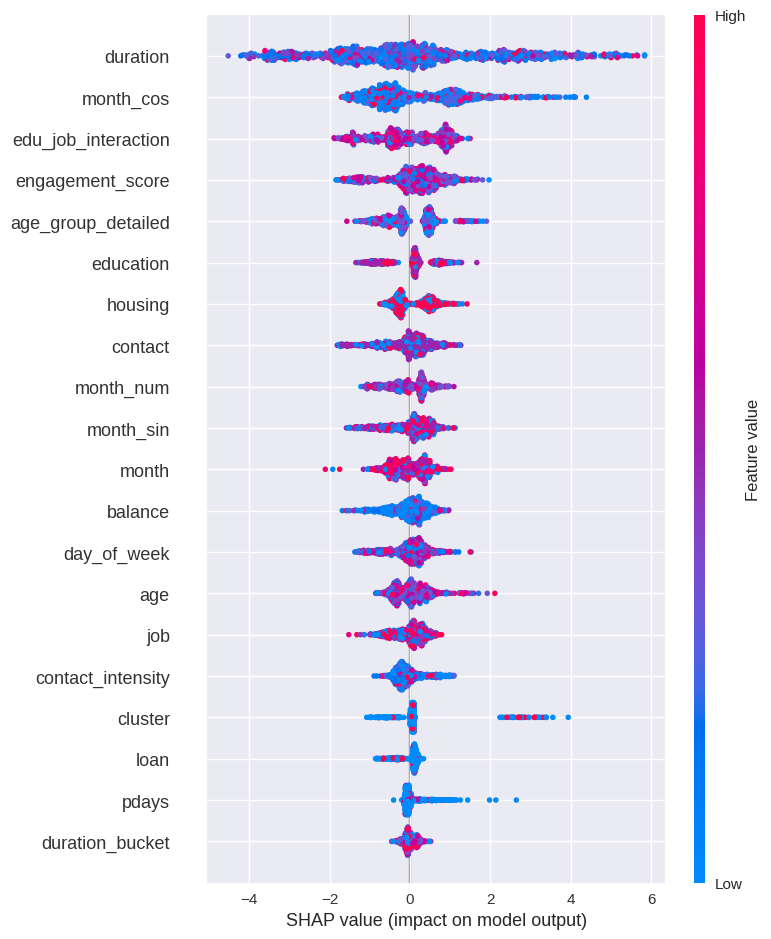

In [11]:
# ============================================================================
# STEP 8: MODEL INTERPRETABILITY (SHAP) — OPTIONAL
# ============================================================================

if SHAP_AVAILABLE:
    show_header('STEP 8: SHAP INTERPRETABILITY (OPTIONAL)')
    # Choose best single model by test AUC
    best_single = max((k,v) for k,v in best_models.items() if k != 'Ensemble')
    model_name, model_info = best_single
    print('Running SHAP for:', model_name)
    try:
        explainer = shap.Explainer(model_info['model'], X_test_selected)
        shap_values = explainer(X_test_selected.sample(min(1000, len(X_test_selected))))
        shap.summary_plot(shap_values, X_test_selected.sample(min(1000, len(X_test_selected))), show=True)
    except Exception as e:
        print('SHAP analysis failed:', e)
else:
    print('\nSHAP not available — skip interpretability step (install shap to enable).')

In [18]:
# ============================================================================
# STEP 9: CAMPAIGN OPTIMIZATION (ACTUAL & EXPECTED-PROFIT SELECTION)
# ============================================================================

show_header('STEP 9: CAMPAIGN OPTIMIZATION')

# Business parameters
REVENUE_PER_CONVERSION = 1000
COST_PER_CONTACT = 50
CAMPAIGN_BUDGET = 50000

# Select which model's probabilities to use: choose the best test_auc available
model_for_campaign = max(best_models.keys(), key=lambda k: best_models[k].get('test_auc', -1))
print('Using model for campaign optimization:', model_for_campaign)
probs = best_models[model_for_campaign]['probabilities']

# Build test_customers DataFrame
test_customers = pd.DataFrame({'customer_id': np.arange(len(X_test_selected)),
                               'response_probability': probs,
                               'actual_response': y_test.values})
# quartiles
test_customers['prob_quartile'] = pd.qcut(test_customers['response_probability'], q=4, labels=['Low','Medium','High','Very_High'])

# Strategy definitions (same as earlier): thresholds + Top10/25/All
probability_thresholds = [0.1,0.2,0.3,0.4,0.5]
strategies = {}
for t in probability_thresholds:
    strategies[f'Prob_>{t:.2f}'] = test_customers[test_customers['response_probability'] > t].copy()
strategies['Target_All'] = test_customers.copy()
strategies['Top_10%'] = test_customers.nlargest(max(1, len(test_customers)//10), 'response_probability').copy()
strategies['Top_25%'] = test_customers.nlargest(max(1, len(test_customers)//4), 'response_probability').copy()

# Evaluate strategies under budget (actual-response simulation)
strategy_results_actual = {}
max_contactable = CAMPAIGN_BUDGET // COST_PER_CONTACT

for name, customers in strategies.items():
    n_customers = len(customers)
    if n_customers == 0:
        strategy_results_actual[name] = {'customers_contacted':0,'total_cost':0,'actual_conversions':0,'actual_revenue':0,'actual_profit':0,'roi':0,'conversion_rate':0,'avg_probability':0}
        continue
    actual_contact = min(n_customers, int(max_contactable))
    if n_customers > actual_contact:
        selected = customers.nlargest(actual_contact, 'response_probability')
    else:
        selected = customers
    total_cost = actual_contact * COST_PER_CONTACT
    actual_conversions = int(selected['actual_response'].sum())
    actual_revenue = actual_conversions * REVENUE_PER_CONVERSION
    actual_profit = actual_revenue - total_cost
    roi = (actual_profit / total_cost) * 100 if total_cost > 0 else 0
    conv_rate = selected['actual_response'].mean() if len(selected)>0 else 0
    strategy_results_actual[name] = {'customers_contacted':actual_contact,'total_cost':total_cost,'actual_conversions':actual_conversions,'actual_revenue':actual_revenue,'actual_profit':actual_profit,'roi':roi,'conversion_rate':conv_rate,'avg_probability':selected['response_probability'].mean() if len(selected)>0 else 0}

strategy_df_actual = pd.DataFrame(strategy_results_actual).T.sort_values('roi', ascending=False)
print('Actual-response simulation results:')
display(strategy_df_actual.round(3))




STEP 9: CAMPAIGN OPTIMIZATION

Using model for campaign optimization: Ensemble
Actual-response simulation results:


,customers_contacted,total_cost,actual_conversions,actual_revenue,actual_profit,roi,conversion_rate,avg_probability
Prob_>0.50,943.0,47150.0,575.0,575000.0,527850.0,1119.512,0.610,0.720
Top_10%,904.0,45200.0,550.0,550000.0,504800.0,1116.814,0.608,0.729
Prob_>0.10,1000.0,50000.0,601.0,601000.0,551000.0,1102.000,0.601,0.707
Prob_>0.20,1000.0,50000.0,601.0,601000.0,551000.0,1102.000,0.601,0.707
Prob_>0.40,1000.0,50000.0,601.0,601000.0,551000.0,1102.000,0.601,0.707
Prob_>0.30,1000.0,50000.0,601.0,601000.0,551000.0,1102.000,0.601,0.707
Target_All,1000.0,50000.0,601.0,601000.0,551000.0,1102.000,0.601,0.707
Top_25%,1000.0,50000.0,601.0,601000.0,551000.0,1102.000,0.601,0.707


In [19]:
# === Expected-profit selection (greedy knapsack-like) ===
# Since cost per contact is identical for everyone, selecting by expected profit per-customer is optimal.
# expected_profit_i = p_i * REVENUE_PER_CONVERSION - COST_PER_CONTACT

test_customers['expected_profit'] = test_customers['response_probability'] * REVENUE_PER_CONVERSION - COST_PER_CONTACT
# Sort by expected profit descending and pick top until budget exhausted (skip negative expected profits)
candidates = test_customers[test_customers['expected_profit'] > 0].sort_values('expected_profit', ascending=False).copy()
max_contacts = int(CAMPAIGN_BUDGET // COST_PER_CONTACT)
selected_expected = candidates.head(max_contacts)

total_expected_cost = len(selected_expected) * COST_PER_CONTACT
# Expected conversions (sum of probabilities)
expected_conversions = selected_expected['response_probability'].sum()
expected_revenue = expected_conversions * REVENUE_PER_CONVERSION
expected_profit = expected_revenue - total_expected_cost
expected_roi = (expected_profit / total_expected_cost) * 100 if total_expected_cost>0 else 0

print('\nExpected-profit greedy selection summary:')
print(f'  Selected customers: {len(selected_expected)}')
print(f'  Total expected conversions: {expected_conversions:.2f}')
print(f'  Expected revenue: ${expected_revenue:,.2f}')
print(f'  Expected profit: ${expected_profit:,.2f} (ROI {expected_roi:.1f}%)')

# Compare with 'Top_10%' and best actual strategy
best_actual = strategy_df_actual['roi'].idxmax() if len(strategy_df_actual)>0 else None
print('\nBest actual-response strategy (by ROI):', best_actual)

# %% [markdown]
# **Explanation**
# - The *actual-response simulation* uses observed responses in the test set to compute realized conversions and ROI for each strategy under the campaign budget.
# - The *expected-profit* selection ranks customers by `p_i * revenue - cost` and picks the top customers until the budget is exhausted. Since cost per contact is constant, this greedy method is optimal for maximizing expected profit.


Expected-profit greedy selection summary:
  Selected customers: 1000
  Total expected conversions: 706.90
  Expected revenue: $706,901.41
  Expected profit: $656,901.41 (ROI 1313.8%)

Best actual-response strategy (by ROI): Prob_>0.50



STEP 10: VISUALIZATIONS & FINAL SUMMARY



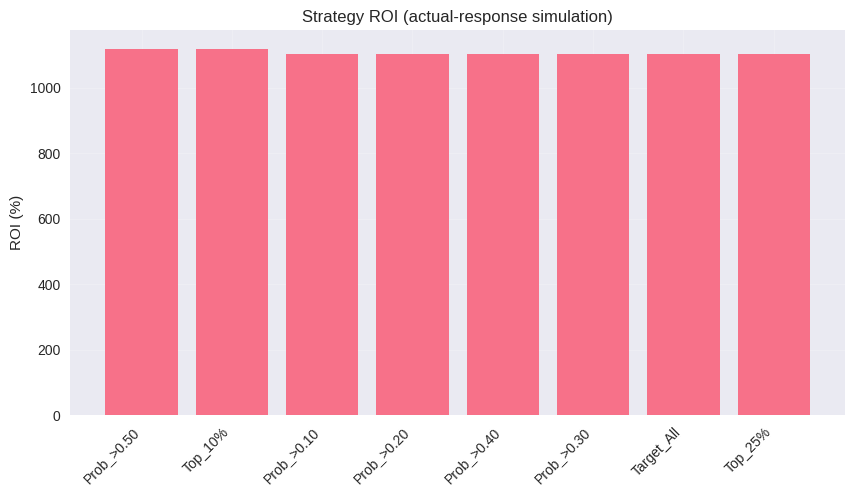

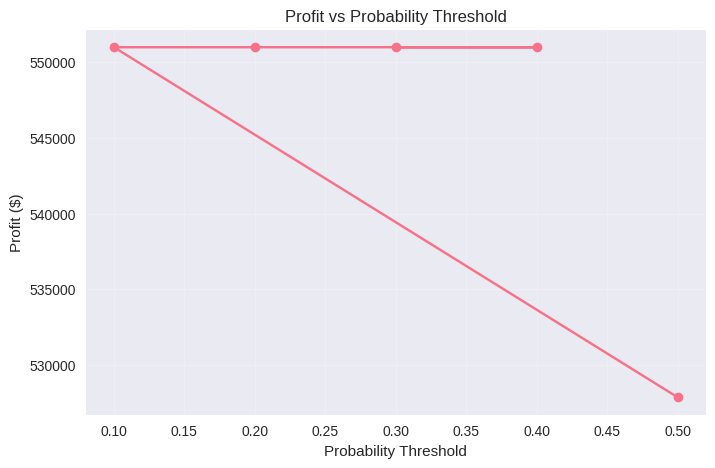

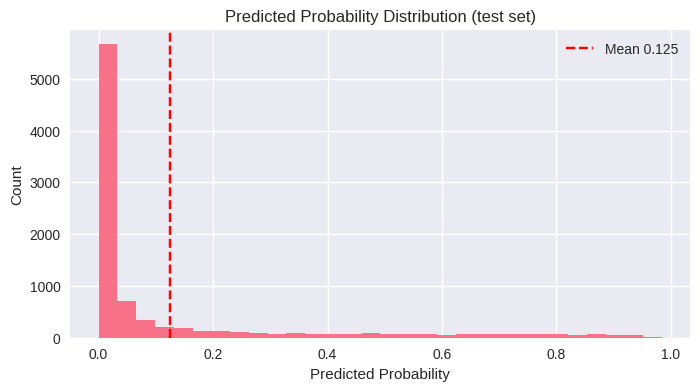

In [20]:
# ============================================================================
# STEP 10: VISUALIZATIONS & FINAL SUMMARY
# ============================================================================

show_header('STEP 10: VISUALIZATIONS & FINAL SUMMARY')

# Strategy ROI barplot
plt.figure(figsize=(10,5))
strategy_df_actual_sorted = strategy_df_actual.sort_values('roi', ascending=False)
plt.bar(strategy_df_actual_sorted.index, strategy_df_actual_sorted['roi'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('ROI (%)')
plt.title('Strategy ROI (actual-response simulation)')
plt.grid(alpha=0.2)
plt.show()

# Profit vs probability threshold for threshold strategies
threshold_names = [n for n in strategy_df_actual.index if n.startswith('Prob_>')]
if len(threshold_names)>0:
    plt.figure(figsize=(8,5))
    profits = strategy_df_actual.loc[threshold_names, 'actual_profit']
    probs = [float(n.split('>')[1]) for n in threshold_names]
    plt.plot(probs, profits.values, marker='o')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Profit ($)')
    plt.title('Profit vs Probability Threshold')
    plt.grid(alpha=0.2)
    plt.show()

# Probability distribution
plt.figure(figsize=(8,4))
plt.hist(test_customers['response_probability'], bins=30)
plt.axvline(test_customers['response_probability'].mean(), linestyle='--', color='red', label=f'Mean {test_customers["response_probability"].mean():.3f}')
plt.title('Predicted Probability Distribution (test set)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

In [21]:
# Final summary printout
print('\nFINAL SUMMARY:')
print(f"  Best model for campaign: {model_for_campaign} with Test AUC {best_models[model_for_campaign]['test_auc']:.4f}")
if len(strategy_df_actual)>0:
    print(f"  Recommended strategy (actual-sim): {strategy_df_actual['roi'].idxmax()} | ROI: {strategy_df_actual['roi'].max():.1f}%")
print(f"  Expected-profit greedy selection ROI: {expected_roi:.1f}% | Expected Profit: ${expected_profit:,.0f}")

print('\nCompleted end-to-end notebook for enhanced marketing campaign optimization.')



FINAL SUMMARY:
  Best model for campaign: Ensemble with Test AUC 0.9310
  Recommended strategy (actual-sim): Prob_>0.50 | ROI: 1119.5%
  Expected-profit greedy selection ROI: 1313.8% | Expected Profit: $656,901

Completed end-to-end notebook for enhanced marketing campaign optimization.
